# Seismic Geometry, Shot Gather and Mid-point Gather

In [58]:
using Pkg; Pkg.add(url="https://github.com/slimgroup/SeisJOLI.jl.git")

In [7]:
using JLD2, JUDI, PyPlot, LinearAlgebra, SlimPlotting, SeisJOLI

# Physical problem setup

# Grid

We start by defining the parameters needed for a cartesian grid:

⋅ A shape  
⋅ A grid spacing in each direction  
⋅ An origin

In [8]:
shape = (201, 201) # Number of gridpoints nx, nz
spacing = (10.0, 10.0) # in meters here
origin = (0.0, 0.0) # In meters as well

(0.0, 0.0)

# Physical object

In [9]:
int(x) = ceil(Int8, x)

int (generic function with 1 method)

Let’s make a simple three layer velocity model

In [45]:
# Define the velocity (in km/sec=m/ms)
vp = 1.5f0 * ones(Float32, shape)
vp[:, 50:end] .= 2.0f0
for i = 1:201
    vp[i, int(1/2*i)+90:201] .= 2.5f0
end
# Create a physical parameter
VP = PhysicalParameter(vp, spacing, origin);

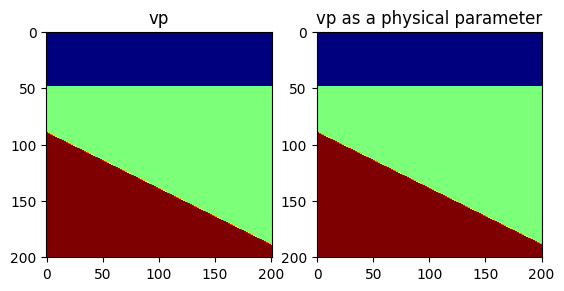

PyObject Text(0.5, 1.0, 'vp as a physical parameter')

In [46]:
figure()
subplot(121)
imshow(vp', cmap="jet")
title("vp")
subplot(122)
imshow(VP', cmap="jet")
title("vp as a physical parameter")

Let’s plot the velocities. Because we adopt a standad cartesian
dimension ordering for generality (X, Z) in 2D and (X, Y, Z) in 3D, we
plot the transpose of the velocity for proper visualization.

# Model

JUDI provide a Model structure that wraps multiple physical parameters
together.

In [47]:
model = Model(shape, spacing, origin, 1f0./vp.^2f0)

Model (n=(201, 201), d=(10.0f0, 10.0f0), o=(0.0f0, 0.0f0)) with parameters [:m]

# Acquisition Geometry

The first thing we need is an acquisiton geometry. In JUDI there is two
ways to create a Geometry.

⋅ By hand, as we will show here  
⋅ From a SEGY file, as we will show in a follow-up tutorial

We create a split-spread geomtry with sources at the top and receivers
at the ocean bottom (top of second layer).

##### Note:

JUDI currently expects all three coordinates to be inputed to setup a
Geometry in 2D as well. This will be fixed in a later version of JUDI.

In [48]:
# Sources position
nsrc = 101 # Number of sources
xsrc = range(0f0, (shape[1] -1)*spacing[1], length=nsrc)
ysrc = 0f0 .* xsrc # this a 2D case so we set y to zero
zsrc = 12.5f0*ones(Float32, nsrc);

Now this definition creates a single Array of position, which would
correspond to a single Simultenous source. Since we are interested in
single source experiments here, we convert these position into an Array
of Array of size nsrc where each sub-array is a single source position

In [49]:
xsrc, ysrc, zsrc = convertToCell.([xsrc, ysrc, zsrc]);

In [50]:
# OBN position
nrec = 101 # Number of receivers
xrec = range(0f0, (shape[1] -1)*spacing[1], length=nrec)
yrec = 0f0 # this a 2D case so we set y to zero. This can be a single number for receivers
zrec = (50*spacing[1])*ones(Float32, nrec);

The last step to be able to create and acquisiton geometry is to define
a recording time and sampling rate

In [51]:
record_time = 2000f0 # Recording time in ms (since we have m/ms for the velocity)
sampling_rate = 4f0; # Let's use a standard 4ms sampling rate

Now we can create the source and receivers geometry

In [52]:
src_geom = Geometry(xsrc, ysrc, zsrc; dt=sampling_rate, t=record_time)
# For the receiver geometry, we specify the number of source to tell JUDI to use the same receiver position for all sources
rec_geom = Geometry(xrec, yrec, zrec, dt=sampling_rate, t=record_time, nsrc=nsrc);

Let’s visualize the geometry onto the model

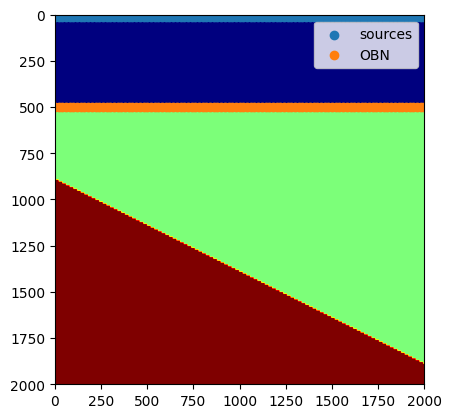

PyObject <matplotlib.legend.Legend object at 0x7fcf30cee0d0>

In [53]:
figure();
imshow(vp', cmap="jet", extent=[0, (shape[1]-1)*spacing[1], (shape[2]-1)*spacing[2], 0])
scatter(xsrc, zsrc, label=:sources)
scatter(xrec, zrec, label="OBN")
legend()

## Plot Acquisition Geometry

In [54]:
# square 2D case: # of sources = # of receivers
idx = 1:5:nsrc # 5 is sub-sampling mask interval so you will look at every 5th source in shot-receiver domain

1:5:101

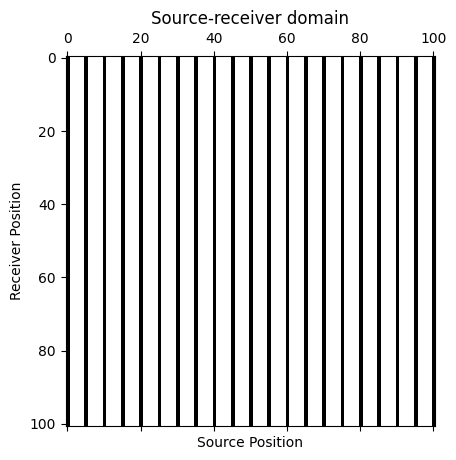

PyObject Text(23.999999999999993, 0.5, 'Receiver Position')

In [55]:
# mask in the source-receiver domain
SR_Mask = zeros(nsrc,nrec);
SR_Mask[:,idx] .= 1;

#plot SR-mask
figure(),spy(SR_Mask)
title("Source-receiver domain")
xlabel("Source Position")
ylabel("Receiver Position")

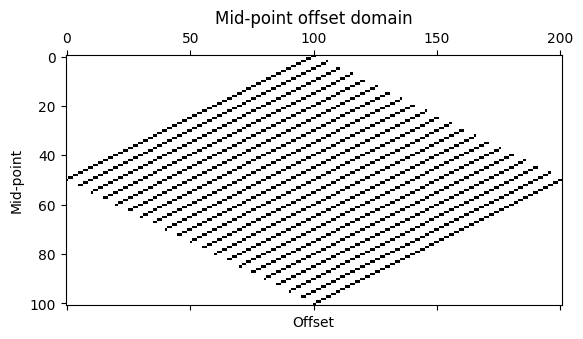

PyObject Text(24.000000000000007, 0.5, 'Mid-point')

In [56]:
# transfer the mask to the midpoint-offset domain
SR = joSRtoCMO(nsrc,nrec,DDT=Float64);
MO_Mask = reshape(SR*vec(SR_Mask), nsrc,2*nrec-1);

#plot MO-mask
figure(),spy(MO_Mask);
title("Mid-point offset domain")
xlabel("Offset")
ylabel("Mid-point")

# Modeling

Now that we have a seismic model, we will generate a few shot records.

## Source wavelet

For the source wavelet, we will use a standard Ricker wavelet at 10Hz.

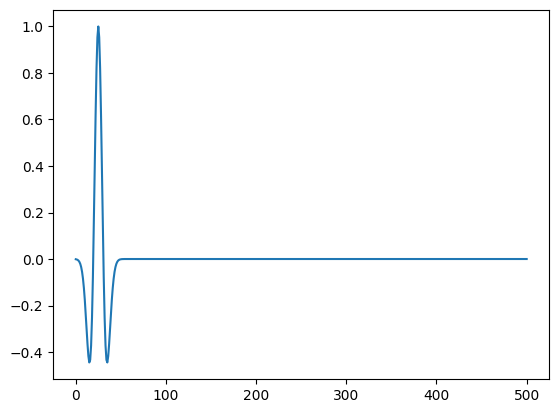

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcecb20fc40>

In [57]:
f0 = 0.010 # Since we use ms, the frequency is in KHz
wavelet = ricker_wavelet(record_time, sampling_rate, f0);
plot(wavelet)

# judiVector

In order to represent seismic data, JUDI provide the judiVector type.
This type wraps a geometry with the seismic data corresponding to it.
Let’s cretae one for the source

In [58]:
q = judiVector(src_geom, wavelet)

judiVector{Float32, Matrix{Float32}} with 101 sources

# Linear operator

The last step to model our seismic data is to create the linear operator
representing the discretized wave equation on the Model we defined. We
also need to define the linear operator corresponding to the source
injection and the receiver interpolation.

In [59]:
Pr = judiProjection(rec_geom) # receiver interpolation
Ps = judiProjection(src_geom) # Source interpolation
Ainv = judiModeling(model) # Inverse of the disrete wave equation.

JUDI forward{Float32} propagator (x * z * time) -> (x * z * time)

# Seismic Data Generation

Now that we have all our operators setup we can finally generate
synthetic data with a simple mat-vec product.

In [60]:
d_obs = Pr * Ainv * Ps' * q

Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.09 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.09 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.09 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.09 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.08 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.08 s
Operator `

judiVector{Float32, Matrix{Float32}} with 101 sources

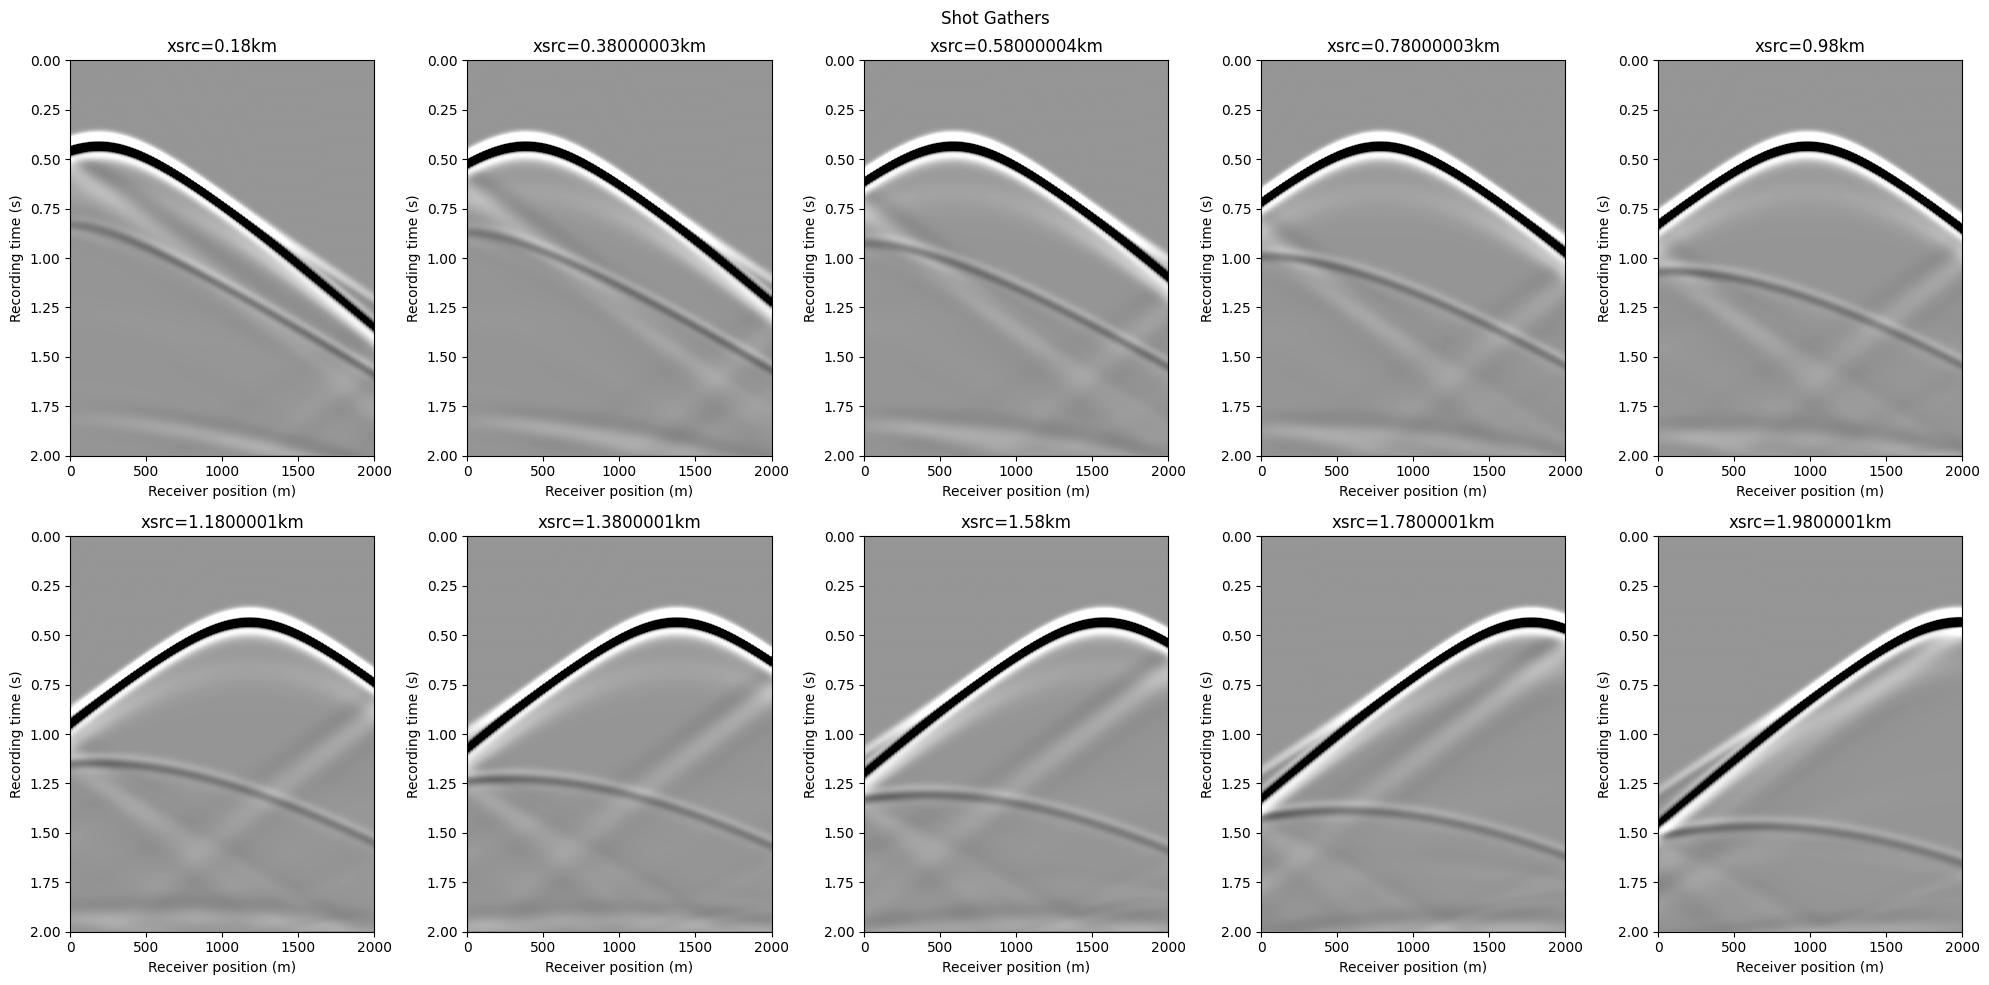

In [61]:
data_extent = [xrec[1], xrec[end], 1f-3*record_time, 0]
figure(figsize=(20, 10))
for i=1:10
    subplot(2, 5, i)
    imshow(d_obs.data[10*i], vmin=-1, vmax=1, cmap="Greys", extent=data_extent, aspect="auto")
    xlabel("Receiver position (m)")
    ylabel("Recording time (s)")
    title("xsrc=$(1f-3xsrc[10*i][1])km")
end
suptitle("Shot Gathers")
tight_layout()

Q. 1) Generate five different seismic dataset by changing
source-receiver configuration (number of sources and receivers) and plot
ten shot gathers for each.

Q. 2) Generate and plot two different acquisiton geometries (in both
domain) by changing subsampling mask for each source-receiver
configuration from the above question. This means you need to plot a
total of twenty figures (2 domain \* two different sub-sampling mask \*
five source-receiver configurations).